In [1]:
import numpy as np
from numpy import genfromtxt
import pylab as pl
from io import StringIO
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

import urllib
import random
import sys

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.layers.wrappers import TimeDistributed
from keras.utils import to_categorical
from keras.models import load_model
from keras.models import model_from_json
from keras.models import Model

from IPython.display import clear_output
import re

Using TensorFlow backend.


In [2]:
from keras.applications.mobilenet import MobileNet
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import DenseNet169
from keras.applications.densenet import DenseNet201
from keras.applications.nasnet import NASNetLarge
from keras.applications.nasnet import NASNetMobile

from keras.applications import mobilenet
# from keras.applications.mobilenet import preprocess_input, decode_predictions
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras import applications
import tensorflow as tf
from tensorflow.python.framework import ops

# Imports
import os, os.path, gc, time, shutil, matplotlib, glob

## Load image list and set image path

In [4]:
# Image set directory root
# chapinero
imgRoot = '/Users/SerG1oAC/Documents/dbintroUdacity/fullstack/vagrant/ggStreetView/map/localidades/chapinero/imgs/'
# martires
# imgRoot = '/Users/SerG1oAC/Documents/dbintroUdacity/fullstack/vagrant/ggStreetView/map/localidades/martires/imgs/'
# usaquen
# imgRoot = '/Users/SerG1oAC/Documents/dbintroUdacity/fullstack/vagrant/ggStreetView/map/localidades/usaquen/imgs_usaquen/'

# Load published images
# chapinero
pblImgFile = open('mstrPublishedLst', 'r')
# martires
# pblImgFile = open('mstrPublishedLst_Martires', 'r')
# usaquen
# pblImgFile = open('mstrPublishedLst_Usaquen', 'r')

pblImgSet =  pblImgFile.readlines() 
print('Published Image quantity: ' + str(len(pblImgSet)))
print(pblImgSet[0][:-2])
print(pblImgSet[len(pblImgSet) - 1][:-2])
print(pblImgSet[-1][:-2])

Published Image quantity: 5505
'4.62406833671_-74.0571218553_-90.jpg'
'4.6461951_-74.0536636_180.jpg'
'4.6461951_-74.0536636_180.jpg'


## Load VGG19 model without output layer

In [5]:
modelVGG19 = VGG19(weights='imagenet', include_top=False, pooling='avg')

In [6]:
img_path = imgRoot + pblImgSet[np.int(0.0)][:-2].replace("'", "")
# load image setting the image size to 224 x 224
img = image.load_img(img_path, target_size=(224, 224))
img4nas = image.load_img(img_path, target_size=(331, 331))
# convert image to numpy array
x = image.img_to_array(img)
# the image is now in an array of shape (3, 224, 224) 
# need to expand it to (1, 3, 224, 224) as it's expecting a list
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

x4nas = image.img_to_array(img4nas)
# the image is now in an array of shape (3, 224, 224) 
# need to expand it to (1, 3, 224, 224) as it's expecting a list
x4nas = np.expand_dims(x4nas, axis=0)
x4nas = preprocess_input(x4nas)

print("Image Shape: " ,x.shape )
print("Image 4 Nas Shape: " ,x4nas.shape )
# extract the features

featuresmodelVGG19 = modelVGG19.predict(x)[0]
print("VGG19: ", featuresmodelVGG19.shape)


Image Shape:  (1, 224, 224, 3)
Image 4 Nas Shape:  (1, 331, 331, 3)
VGG19:  (512,)


## Generate and save VGG19 based image descriptors

In [7]:

imgFeatureSet = np.zeros((len(pblImgSet), featuresmodelVGG19.shape[0])) 
print("imgFeatureSet :", imgFeatureSet.shape)

def getImgSetFeatures(model, imgRef, masterImgList):
    pblImgFile = open(masterImgList, 'r') 
    pblImgSet =  pblImgFile.readlines() 
    print('Published Image quantity: ' + str(len(pblImgSet)))
   
    imgCounter = 0
    for v in pblImgSet:
        imgPath = imgRoot + v[:-2].replace("'", "")
        img = image.load_img(imgPath, target_size=(imgRef.shape[1], imgRef.shape[2]))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        imgFeatureSet[imgCounter] = model.predict(x)[0]
        imgCounter = imgCounter + 1
        if imgCounter % 10 == 0:
            clear_output(wait=True)
            print ("Cost after epoch %i: %f" % (imgCounter, 100*(imgCounter/len(pblImgSet))))
            


        

imgFeatureSet : (5505, 512)


In [8]:
getImgSetFeatures(modelVGG19, x, 'mstrPublishedLst')

Cost after epoch 5500: 99.909173


In [9]:
np.savetxt("VGG19Chapinero_Ftrs.csv", imgFeatureSet, delimiter=",")

In [20]:
print(imgFeatureSet[0,:])

[  7.00259149e-01   0.00000000e+00   0.00000000e+00   5.45773953e-02
   1.22547541e+01   4.19673651e-01   0.00000000e+00   4.11977954e-02
   1.14436257e+00   3.52895319e-01   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   8.62121284e-01
   0.00000000e+00   3.70051920e-01   0.00000000e+00   0.00000000e+00
   5.37817001e+00   1.47125988e+01   2.17260733e-01   0.00000000e+00
   5.21877825e-01   0.00000000e+00   2.09709620e+00   7.66196728e-01
   3.25401497e+00   0.00000000e+00   8.77244771e-01   0.00000000e+00
   2.64648527e-01   0.00000000e+00   1.84404194e+00   0.00000000e+00
   1.01462014e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   3.76028232e-02   0.00000000e+00   4.91837084e-01   5.96052967e-02
   0.00000000e+00   4.82262701e-01   1.37673492e+01   4.40700874e-02
   0.00000000e+00   5.38695335e+00   1.14731455e+00   2.42062733e-02
   3.11903596e-01   3.96084994e-01   4.99453098e-01   7.05833054e+00
   4.86659706e-01   1.15747452e+00

### Building training set

In [2]:
imageFeatures = genfromtxt('VGG16_Ftrs.csv', delimiter=',')

NameError: name 'genfromtxt' is not defined

In [84]:
print(imageFeatures.shape)
imgFtrStd = np.expand_dims(np.std(imageFeatures, axis=0), axis=0) 
imgFtrMean = np.expand_dims(np.mean(imageFeatures, axis=0) , axis=0) 
imgNrmFeatures = ((imageFeatures - imgFtrMean)/imgFtrStd)

(5505, 512)


In [85]:
concaFtr = np.expand_dims( np.concatenate((imgNrmFeatures[1], imgNrmFeatures[2]), axis=0), axis=0 )
print(concaFtr.shape)

(1, 1024)


In [98]:

# Load vote indexer file
votesIndex = genfromtxt('descriptorIndexerNrml_Nov_24.txt', delimiter=',')
print(votesIndex.shape)
print(votesIndex[4][2])

# training percentage
perTrain = 90
print('Training percentage ' , perTrain,'%')
# miniBatch Size
minibatch_size = 128
print('Training mini batch size' , minibatch_size)
# Total amount of training votes
ImgVtTrainSize = np.int(np.floor((votesIndex.shape[0]*perTrain)/100))
print("Total amount of training votes" , ImgVtTrainSize)
# Total amount of test votes
ImgVtTestSize = votesIndex.shape[0] - ImgVtTrainSize
print("Total amount of test votes" , ImgVtTestSize)
num_minibatches = int(ImgVtTrainSize / minibatch_size)
LastBatchSize = ImgVtTrainSize - num_minibatches*minibatch_size
if LastBatchSize > 0:
    num_minibatches = num_minibatches + 1
print("Number of training mini batches" , num_minibatches)
print("Last batch size", LastBatchSize)
#--Test figures
iniTestIdx = ImgVtTrainSize
num_Testminibatches = int(ImgVtTestSize / minibatch_size)
LastTestBatchSize = ImgVtTestSize - num_Testminibatches*minibatch_size
if LastTestBatchSize > 0:
    num_Testminibatches = num_Testminibatches + 1
print("Number of test mini batches" , num_Testminibatches)
print("Last test batch size", LastTestBatchSize)

(14115, 3)
1.0
Training percentage  90 %
Training mini batch size 128
Total amount of training votes 12703
Total amount of test votes 1412
Number of training mini batches 100
Last batch size 31
Number of test mini batches 12
Last test batch size 4


In [99]:
def getMiniBatch(minbIdx):
    # minbIdx: miniBatch index
    # training set permutation array
    iniIdx = minbIdx * minibatch_size
    endIdx = iniIdx + minibatch_size - 1
    if endIdx > (ImgVtTrainSize - 1):
        endIdx = ImgVtTrainSize - 1
    vsize = (endIdx - iniIdx) + 1  
    # build room
    x_train_orig = np.zeros((vsize, imageFeatures.shape[1]*2)) 
    y_train_orig = np.zeros((vsize,1))
    idxIte = 0
    for i in range(iniIdx,(endIdx+1)):
        imgAIdx = votesIndex[i][0] - 1
        imgBIdx = votesIndex[i][1] - 1
        voteCode = votesIndex[i][2]
        
        y_train_orig[idxIte,0] = voteCode
        x_train_orig[idxIte] = np.expand_dims(np.concatenate((imgNrmFeatures[np.int(imgAIdx)], imgNrmFeatures[np.int(imgBIdx)]), axis=0), axis=0)[0]
            
        idxIte =  idxIte + 1

    return  x_train_orig, y_train_orig     
        
    

def getTestMiniBatch(minTbIdx):
    # minbIdx: miniBatch index
    # training set permutation array
    minbIdx = int(minTbIdx%num_Testminibatches)
    
    iniIdx = minbIdx * minibatch_size
    endIdx = iniIdx + minibatch_size - 1
    if endIdx > (ImgVtTestSize - 1):
        endIdx = ImgVtTestSize - 1
    vsize = (endIdx - iniIdx) + 1  
    # build room
    x_train_orig = np.zeros((vsize, imageFeatures.shape[1]*2)) 
    y_train_orig = np.zeros((vsize,1))
    idxIte = 0
    for i in range(iniIdx,(endIdx+1)):
        imgAIdx = votesIndex[i][0] - 1
        imgBIdx = votesIndex[i][1] - 1
        voteCode = votesIndex[i][2]
        
        y_train_orig[idxIte,0] = voteCode
        x_train_orig[idxIte] = np.expand_dims(np.concatenate((imgNrmFeatures[np.int(imgAIdx)], imgNrmFeatures[np.int(imgBIdx)]), axis=0), axis=0)[0]
            
        idxIte =  idxIte + 1
    
    return  x_train_orig, y_train_orig

In [100]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, shape=(None,n_x), name = 'X') 
    Y = tf.placeholder(tf.float32, shape=(None, n_y), name = 'Y')
    
    return X,Y

In [101]:
def forward_propagation(X):
    
    prtVlmSize = True
    
    Z4 = tf.contrib.layers.fully_connected(X, 1024)
    Z5 = tf.contrib.layers.fully_connected(Z4, 512)
    Z6 = tf.contrib.layers.fully_connected(Z5, 1, activation_fn=None)
    
    return Z6

In [102]:
def compute_cost(Z6, Y):
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Z6, labels = Y))
    
    return cost

In [103]:
def model(learning_rate = 0.0001, num_epochs = 50, print_cost = True, minibatch_size = minibatch_size):
    
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
                                        
    costs = []                                        # To keep track of the cost
    Testcosts = []
    lastBestTestCost = 100.
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(imageFeatures.shape[1]*2, 1)
     
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z6 = forward_propagation(X)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z6, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
   
    # SAVER ops
    SIGMOID_op = tf.sigmoid(Z6, name = 'SIGMOID_op')
    PREDICT_op = tf.round(SIGMOID_op, name = 'PREDICT_op')
    OK_PREDICTED_op = tf.equal(PREDICT_op, Y, name = 'OK_PREDICTED_op')
    ACCURACY_op = tf.reduce_mean(tf.cast(OK_PREDICTED_op, "float"), name = 'ACCURACY_op')
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            minibatch_testCost = 0.
            seed = seed + 1
            np.random.seed(seed)
            for it in range(0, num_minibatches):
                X_train, Y_train = getMiniBatch(it)
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: X_train, Y: Y_train})
                minibatch_cost += temp_cost / num_minibatches
               
            for tx in range(0, num_Testminibatches):
                X_test, Y_test = getTestMiniBatch(tx)
                temp_testcost = cost.eval({X: X_test, Y: Y_test})
                minibatch_testCost += temp_testcost/num_Testminibatches
                
            # Print the cost every epoch
            if print_cost == True and epoch % 1 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
                print ("Test Cost after epoch %i: %f" % (epoch, minibatch_testCost))
            # build cost list
            if epoch > 1:
                costs.append(minibatch_cost)
                Testcosts.append(minibatch_testCost)
            # update model if a better test cost is detected
            if minibatch_testCost < lastBestTestCost:
                lastBestTestCost = minibatch_testCost
                # remove previuous best model
                files = glob.glob(modelPath + '/*')
                for f in files:
                    os.remove(f)
                # Save the variables to disk.
                print("Saving a new best model")
                saver.save(sess, modelPath + '/model' + str(int(lastBestTestCost*100))) 
            
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('costs')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        plt.plot(np.squeeze(Testcosts))
        plt.ylabel('test cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
                
        return costs,Testcosts

Cost after epoch 0: 0.596810
Test Cost after epoch 0: 0.726519
Saving a new best model
Cost after epoch 1: 0.511433
Test Cost after epoch 1: 0.616777
Saving a new best model
Cost after epoch 2: 0.447840
Test Cost after epoch 2: 0.536026
Saving a new best model
Cost after epoch 3: 0.394223
Test Cost after epoch 3: 0.471511
Saving a new best model
Cost after epoch 4: 0.347194
Test Cost after epoch 4: 0.414838
Saving a new best model
Cost after epoch 5: 0.304083
Test Cost after epoch 5: 0.361082
Saving a new best model
Cost after epoch 6: 0.263699
Test Cost after epoch 6: 0.308975
Saving a new best model
Cost after epoch 7: 0.226163
Test Cost after epoch 7: 0.259226
Saving a new best model
Cost after epoch 8: 0.191588
Test Cost after epoch 8: 0.210946
Saving a new best model
Cost after epoch 9: 0.160466
Test Cost after epoch 9: 0.166384
Saving a new best model
Cost after epoch 10: 0.133168
Test Cost after epoch 10: 0.127186
Saving a new best model
Cost after epoch 11: 0.110493
Test Cost a

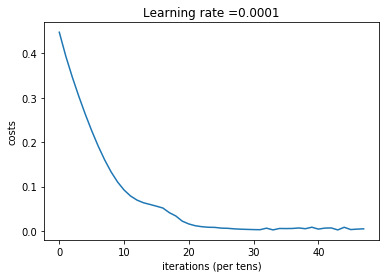

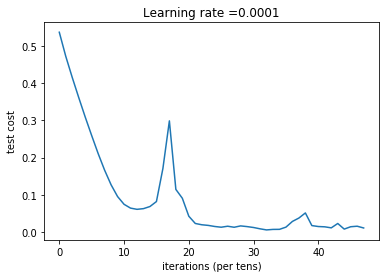

costs [0.44783995360136009, 0.39422304823994636, 0.34719371393322934, 0.30408342368900759, 0.26369897119700919, 0.22616284400224684, 0.19158794168382876, 0.16046606458723545, 0.13316828344017267, 0.11049343304708602, 0.092456463910639261, 0.078946255128830634, 0.069683356545865507, 0.063666253145784141, 0.059910526480525736, 0.05596847699955107, 0.051785427532158763, 0.041291936049237844, 0.033822857763734629, 0.022152981688850548, 0.015955661874613728, 0.011900134106981573, 0.0097788889192452159, 0.0085067237094335734, 0.0081976068230869732, 0.0065674717416550231, 0.0061226799703581504, 0.0049165396198077339, 0.0041272669294994532, 0.0036757000582656497, 0.003252844064336386, 0.0029669134564755967, 0.0064325615453071821, 0.0025445660726109045, 0.0057256823850184452, 0.0055659772586295723, 0.0057813236699075805, 0.0068856962406425712, 0.0051981220922607471, 0.0085800147746340361, 0.0043442517001312806, 0.0065841147987521238, 0.0069555444340949173, 0.0024985501885385029, 0.0084689810570

In [104]:
costs,Testcosts = model()
print('costs', costs)
print('Testcosts', Testcosts)

INFO:tensorflow:Restoring parameters from ./transfer4uspVGG16/model0
Tensor("X:0", shape=(?, 1024), dtype=float32)
Confusion matrix, without normalization
[[ 99 146]
 [195 972]]


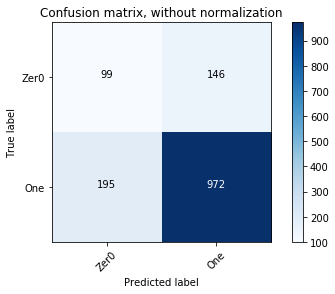

In [106]:
saver4Pre = tf.train.import_meta_graph('./transfer4uspVGG16/model0.meta')
with tf.Session() as sess:
    # Step-2: Now let's load the weights saved using the restore method.
    saver4Pre.restore(sess, tf.train.latest_checkpoint('./transfer4uspVGG16'))
    # Accessing the default graph which we have restored
    graph = tf.get_default_graph()
    # Now, let's get hold of the op that we can be processed to get the output.
    # In the original network y_pred is the tensor that is the prediction of the network
    PREDICT_op = graph.get_tensor_by_name("PREDICT_op:0")
    X = graph.get_tensor_by_name("X:0") 
    print(X)
    Y = graph.get_tensor_by_name("Y:0")
    # for i in range(0, votesIndex.shape[0]):
    X_val = np.zeros((1, imageFeatures.shape[1]*2)) 
    Y_val = np.zeros((1,1))
    # for i in range(0, votesIndex.shape[0]):
    prediction = []
    actulLabel = []
   
    for i in range(12703, 14115):
        # minus 1 because originall indexing list was done in MATLAB.
        # MATLAB index stars at 1
        imgAIdx = votesIndex[i][0] - 1
        imgBIdx = votesIndex[i][1] - 1
        voteCode = votesIndex[i][2]
        
        Y_val[0,0] = voteCode
        X_val[0] = np.expand_dims(np.concatenate((imgNrmFeatures[np.int(imgAIdx)], imgNrmFeatures[np.int(imgBIdx)]), axis=0), axis=0)[0]
        
        result = sess.run(PREDICT_op, feed_dict={X: X_val, Y: Y_val})
        prediction.append(result[0,0])
        actulLabel.append(Y_val[0,0])
        
    
    
    
    
    # pout = np.concatenate((np.transpose(actulLabelArr), np.transpose(predictionArr)), axis=1)
    # print(pout)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(np.asarray(actulLabel), np.asarray(prediction))
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure()
    class_names = ['Zer0', 'One']
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
    plt.show()
    